In [1]:
# venv
import torch
import datetime as dt
print(torch.__version__)

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU found. Using CPU.")

2.0.1+cu117
GPU is available.


In [1]:
import os, subprocess, glob, srt, pickle
# from shutil import rmtree
import cv2
import demoTalkNetMod
from utils import custom_components
# import logging
from datetime import datetime, timedelta
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import srt
import whisper

from stable_whisper import modify_model
from pyannote.core import Segment, Annotation
from pyannote.core import notebook
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()
import torch
from pyannote.audio import Pipeline
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# logger = logging.getLogger("transcribe")

pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.0",
                                               use_auth_token=os.getenv('HUGGINGFACE_TOKEN'))
pretrained_pipeline.to(torch.device("cuda"))
# sys.path.append(os.path.abspath("TalkNet-ASD/"))

2024-01-26 00:51:46.139091229 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-01-26 00:51:46.139120064 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [2]:
class Args:
    def __init__(self, args_dict):
        self.__dict__.update(args_dict)

args_dict = {
    "videoFolder":"Dataset/Videos",
    "outputFolder":"output",
    "pretrainModel":"pretrain_TalkSet.model",
    "nDataLoaderThread":10,
    "facedetScale":0.25,
    "minTrack":10,
    "numFailedDet":10,
    "minFaceSize":1,
    "cropScale":0.40,
    "start":0,
    "duration":0,
    "evalCol":False,
    "colSavePath":"/data08/col",
}

args = Args(args_dict)

if os.path.isfile(args.pretrainModel) == False:  # Download the pretrained model
    Link = "1AbN9fCf9IexMxEKXLQY2KYBlb-IhSEea"
    cmd = "gdown --id %s -O %s" % (Link, args.pretrainModel)
    subprocess.call(cmd, shell=True, stdout=None)


model_name_openai = "medium.en"
model = custom_components.get_whisper_model(model_name_openai)

args.videoFiles = [
    os.path.splitext(f)[0]
    for f in os.listdir(args.videoFolder)
    if os.path.isfile(os.path.join(args.videoFolder, f)) and os.path.splitext(os.path.join(args.videoFolder, f))[1] in [".mp4"]
]
args.videoFiles

['StarTalk_CMBR_92_152',
 'StarTalk_Sleep_2099_2160',
 'StarTalk_CMBR_319_356',
 'StarTalk_CMBR_270_308',
 'StarTalk_Sleep_1602_1639',
 'NDT_India_19_88',
 'StarTalk_FlyingVehicles_674_719',
 'StarTalk_FlyingVehicles_780_811',
 'StarTalk_FlyingVehicles_949_1000',
 'StarTalk_Sleep_1152_1211',
 'StarTalk_FlyingVehicles_2670_2710',
 'StarTalk_CMBR_190_225',
 'StarTalk_FlyingVehicles_1980_2040',
 'MagnusCarlson_542_599',
 'StarTalk_FlyingVehicles_1001_1043',
 'StarTalk_Sleep_1980_2041',
 'StarTalk_FlyingVehicles_2446_2508',
 'StarTalk_Sleep_382_450',
 'StarTalk_Sleep_2379_2443',
 'StarTalk_Sleep_2470_2551',
 'StarTalk_FlyingVehicles_300_340',
 'StarTalk_Sleep_748_796']

In [4]:
args.videoFiles = ['StarTalk_FlyingVehicles_300_340']
args.videoFiles

['StarTalk_FlyingVehicles_300_340']

In [13]:
final_video_output = {}
for video_file in args.videoFiles:
    print(video_file)
    args.videoPath = glob.glob(os.path.join(args.videoFolder, video_file + ".*"))[0]
    args.savePath = os.path.join(args.outputFolder, video_file)
    args.audioFilePath = os.path.join(args.savePath, "pyavi", "audio.wav")
    video = cv2.VideoCapture(args.videoPath)
    args.frameRate = video.get(cv2.CAP_PROP_FPS)
    video.release()
    print(args.frameRate)
    
    vidTracks, scores, args = demoTalkNetMod.preprocess(args)

    df, args = demoTalkNetMod.get_track_face_encodings(vidTracks, scores, args)
    print(args.frameRate)

    # 001 - eps=0.4, min_samples = 4
    # PL - eps=0.5, min_samples = 200
    # Video3 - eps=0.5, min_samples = 100
    # Video2 - eps=0.5, min_samples = 100
    # Choose DBSCAN parameters
#     eps = 0.5
#     min_samples = 100

#     # Apply DBSCAN clustering
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     clusters = dbscan.fit_predict(df["Encoding"].to_list())
#     unique, counts = np.unique(clusters, return_counts=True)
#     print(np.asarray((unique, counts)).T)

    optimal_cluster = -1
    max_silhouette = 0
    encoding_list = df["Encoding"].to_list()
    for num_clusters in range(2,6):   
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(encoding_list)

        silhouette_avg = silhouette_score(encoding_list, cluster_labels)
        if silhouette_avg > max_silhouette:
            max_silhouette = silhouette_avg
            optimal_cluster = num_clusters

    print(optimal_cluster)
    kmeans = KMeans(n_clusters=optimal_cluster, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(encoding_list)

    df["Clusters"] = cluster_labels

    video_output = demoTalkNetMod.get_final_tracks(df, args)

    final_video_output[video_file] = video_output
    
with open("Dataset/video_diarization_output.pckl", "wb") as fil:
    pickle.dump(final_video_output, fil)

final_video_output

StarTalk_CMBR_92_152
23.976023976023978


2024-01-18 13:53:03 Extract the video and save in output/StarTalk_CMBR_92_152/pyavi/video.avi 
2024-01-18 13:53:03 Extract the audio and save in output/StarTalk_CMBR_92_152/pyavi/audio.wav 
2024-01-18 13:53:12 Extract the frames and save in output/StarTalk_CMBR_92_152/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_CMBR_92_152/pyavi/video.avi - scenes detected 6
2024-01-18 13:53:19 Scene detection and save in output/StarTalk_CMBR_92_152/pywork 
2024-01-18 13:54:20 Face detection and save in output/StarTalk_CMBR_92_152/pywork 
2024-01-18 13:54:20 Face track and detected 15 tracks 
100%|█████████████████████████████████████████████████████████████████████████████████████

01-18 13:55:10 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.69it/s]
2024-01-18 13:55:15 Scores extracted and saved in output/StarTalk_CMBR_92_152/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1240/1240 [06:23<00:00,  3.23faces/s]
2024-01-18 14:01:39 Face encoding generation completed

24.993339549753564
2
StarTalk_Sleep_2099_2160
23.976023976023978


2024-01-18 14:01:53 Extract the video and save in output/StarTalk_Sleep_2099_2160/pyavi/video.avi 
2024-01-18 14:01:54 Extract the audio and save in output/StarTalk_Sleep_2099_2160/pyavi/audio.wav 
2024-01-18 14:02:02 Extract the frames and save in output/StarTalk_Sleep_2099_2160/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_Sleep_2099_2160/pyavi/video.avi - scenes detected 12
2024-01-18 14:02:10 Scene detection and save in output/StarTalk_Sleep_2099_2160/pywork 
2024-01-18 14:03:18 Face detection and save in output/StarTalk_Sleep_2099_2160/pywork 
2024-01-18 14:03:18 Face track and detected 22 tracks 
100%|████████████████████████████████████████████████████████████

01-18 14:04:03 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  3.81it/s]
2024-01-18 14:04:08 Scores extracted and saved in output/StarTalk_Sleep_2099_2160/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 976/976 [05:03<00:00,  3.22faces/s]
2024-01-18 14:09:12 Face encoding generation completed

25.045865548420913
4
StarTalk_CMBR_319_356
23.976023976023978


2024-01-18 14:09:21 Extract the video and save in output/StarTalk_CMBR_319_356/pyavi/video.avi 
2024-01-18 14:09:22 Extract the audio and save in output/StarTalk_CMBR_319_356/pyavi/audio.wav 
2024-01-18 14:09:27 Extract the frames and save in output/StarTalk_CMBR_319_356/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_CMBR_319_356/pyavi/video.avi - scenes detected 5
2024-01-18 14:09:31 Scene detection and save in output/StarTalk_CMBR_319_356/pywork 
2024-01-18 14:10:09 Face detection and save in output/StarTalk_CMBR_319_356/pywork 
2024-01-18 14:10:09 Face track and detected 11 tracks 
100%|███████████████████████████████████████████████████████████████████████████████

01-18 14:10:43 Model para number = 15.01


Model pretrain_TalkSet.model loaded from previous state! 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.83it/s]
2024-01-18 14:10:48 Scores extracted and saved in output/StarTalk_CMBR_319_356/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 687/687 [03:33<00:00,  3.22faces/s]
2024-01-18 14:14:21 Face encoding generation completed

25.0
2
StarTalk_CMBR_270_308
23.976023976023978


2024-01-18 14:14:30 Extract the video and save in output/StarTalk_CMBR_270_308/pyavi/video.avi 
2024-01-18 14:14:31 Extract the audio and save in output/StarTalk_CMBR_270_308/pyavi/audio.wav 
2024-01-18 14:14:36 Extract the frames and save in output/StarTalk_CMBR_270_308/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_CMBR_270_308/pyavi/video.avi - scenes detected 8
2024-01-18 14:14:40 Scene detection and save in output/StarTalk_CMBR_270_308/pywork 
2024-01-18 14:15:20 Face detection and save in output/StarTalk_CMBR_270_308/pywork 
2024-01-18 14:15:20 Face track and detected 15 tracks 
100%|███████████████████████████████████████████████████████████████████████████████

01-18 14:15:55 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.45it/s]
2024-01-18 14:16:00 Scores extracted and saved in output/StarTalk_CMBR_270_308/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 676/676 [03:30<00:00,  3.22faces/s]
2024-01-18 14:19:30 Face encoding generation completed

24.98686284813452
2
StarTalk_Sleep_1602_1639
23.976023976023978


2024-01-18 14:19:39 Extract the video and save in output/StarTalk_Sleep_1602_1639/pyavi/video.avi 
2024-01-18 14:19:40 Extract the audio and save in output/StarTalk_Sleep_1602_1639/pyavi/audio.wav 
2024-01-18 14:19:45 Extract the frames and save in output/StarTalk_Sleep_1602_1639/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_Sleep_1602_1639/pyavi/video.avi - scenes detected 3
2024-01-18 14:19:49 Scene detection and save in output/StarTalk_Sleep_1602_1639/pywork 
2024-01-18 14:20:29 Face detection and save in output/StarTalk_Sleep_1602_1639/pywork 
2024-01-18 14:20:29 Face track and detected 5 tracks 
100%|██████████████████████████████████████████████████████████████

01-18 14:20:51 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]
2024-01-18 14:20:53 Scores extracted and saved in output/StarTalk_Sleep_1602_1639/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 757/757 [03:56<00:00,  3.21faces/s]
2024-01-18 14:24:49 Face encoding generation completed

25.01752304954979
3
NDT_India_19_88
29.97002997002997


2024-01-18 14:25:03 Extract the video and save in output/NDT_India_19_88/pyavi/video.avi 
2024-01-18 14:25:04 Extract the audio and save in output/NDT_India_19_88/pyavi/audio.wav 
2024-01-18 14:25:13 Extract the frames and save in output/NDT_India_19_88/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/NDT_India_19_88/pyavi/video.avi - scenes detected 5
2024-01-18 14:25:21 Scene detection and save in output/NDT_India_19_88/pywork 
2024-01-18 14:27:13 Face detection and save in output/NDT_India_19_88/pywork 
2024-01-18 14:27:13 Face track and detected 36 tracks 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████

01-18 14:28:53 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.05it/s]
2024-01-18 14:29:05 Scores extracted and saved in output/NDT_India_19_88/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1191/1191 [06:09<00:00,  3.22faces/s]
2024-01-18 14:35:15 Face encoding generation completed

25.033300515434068
5
StarTalk_FlyingVehicles_674_719
24.0


2024-01-18 14:35:23 Extract the video and save in output/StarTalk_FlyingVehicles_674_719/pyavi/video.avi 
2024-01-18 14:35:23 Extract the audio and save in output/StarTalk_FlyingVehicles_674_719/pyavi/audio.wav 
2024-01-18 14:35:25 Extract the frames and save in output/StarTalk_FlyingVehicles_674_719/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 854 x 480
INFO:pyscenedetect:Downscale factor set to 3, effective resolution: 284 x 160
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_FlyingVehicles_674_719/pyavi/video.avi - scenes detected 4
2024-01-18 14:35:27 Scene detection and save in output/StarTalk_FlyingVehicles_674_719/pywork 
2024-01-18 14:35:44 Face detection and save in output/StarTalk_FlyingVehicles_674_719/pywork 
2024-01-18 14:35:44 Face track and detected 9 tracks 
100%|██████████████████████

01-18 14:36:03 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.54it/s]
2024-01-18 14:36:08 Scores extracted and saved in output/StarTalk_FlyingVehicles_674_719/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 957/957 [04:48<00:00,  3.32faces/s]
2024-01-18 14:40:57 Face encoding generation completed

24.98834912673931
3
StarTalk_FlyingVehicles_780_811
24.0


2024-01-18 14:41:03 Extract the video and save in output/StarTalk_FlyingVehicles_780_811/pyavi/video.avi 
2024-01-18 14:41:04 Extract the audio and save in output/StarTalk_FlyingVehicles_780_811/pyavi/audio.wav 
2024-01-18 14:41:05 Extract the frames and save in output/StarTalk_FlyingVehicles_780_811/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 854 x 480
INFO:pyscenedetect:Downscale factor set to 3, effective resolution: 284 x 160
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_FlyingVehicles_780_811/pyavi/video.avi - scenes detected 7
2024-01-18 14:41:07 Scene detection and save in output/StarTalk_FlyingVehicles_780_811/pywork 
2024-01-18 14:41:18 Face detection and save in output/StarTalk_FlyingVehicles_780_811/pywork 
2024-01-18 14:41:18 Face track and detected 13 tracks 
100%|█████████████████████

01-18 14:41:35 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:04<00:00,  3.06it/s]
2024-01-18 14:41:39 Scores extracted and saved in output/StarTalk_FlyingVehicles_780_811/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 652/652 [03:16<00:00,  3.32faces/s]
2024-01-18 14:44:55 Face encoding generation completed

24.98390212491951
3
StarTalk_FlyingVehicles_949_1000
24.0


2024-01-18 14:45:03 Extract the video and save in output/StarTalk_FlyingVehicles_949_1000/pyavi/video.avi 
2024-01-18 14:45:03 Extract the audio and save in output/StarTalk_FlyingVehicles_949_1000/pyavi/audio.wav 
2024-01-18 14:45:05 Extract the frames and save in output/StarTalk_FlyingVehicles_949_1000/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 854 x 480
INFO:pyscenedetect:Downscale factor set to 3, effective resolution: 284 x 160
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_FlyingVehicles_949_1000/pyavi/video.avi - scenes detected 12
2024-01-18 14:45:08 Scene detection and save in output/StarTalk_FlyingVehicles_949_1000/pywork 
2024-01-18 14:45:28 Face detection and save in output/StarTalk_FlyingVehicles_949_1000/pywork 
2024-01-18 14:45:28 Face track and detected 19 tracks 
100%|██████████████

01-18 14:45:49 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.48it/s]
2024-01-18 14:45:54 Scores extracted and saved in output/StarTalk_FlyingVehicles_949_1000/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1049/1049 [05:15<00:00,  3.32faces/s]
2024-01-18 14:51:10 Face encoding generation completed

24.992171598559576
3
StarTalk_Sleep_1152_1211
23.976023976023978


2024-01-18 14:51:23 Extract the video and save in output/StarTalk_Sleep_1152_1211/pyavi/video.avi 
2024-01-18 14:51:23 Extract the audio and save in output/StarTalk_Sleep_1152_1211/pyavi/audio.wav 
2024-01-18 14:51:31 Extract the frames and save in output/StarTalk_Sleep_1152_1211/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_Sleep_1152_1211/pyavi/video.avi - scenes detected 9
2024-01-18 14:51:37 Scene detection and save in output/StarTalk_Sleep_1152_1211/pywork 
2024-01-18 14:52:37 Face detection and save in output/StarTalk_Sleep_1152_1211/pywork 
2024-01-18 14:52:37 Face track and detected 14 tracks 
100%|█████████████████████████████████████████████████████████████

01-18 14:53:13 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.25it/s]
2024-01-18 14:53:18 Scores extracted and saved in output/StarTalk_Sleep_1152_1211/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1188/1188 [06:11<00:00,  3.20faces/s]
2024-01-18 14:59:29 Face encoding generation completed

24.990264632680358
3
StarTalk_FlyingVehicles_2670_2710
24.0


2024-01-18 14:59:36 Extract the video and save in output/StarTalk_FlyingVehicles_2670_2710/pyavi/video.avi 
2024-01-18 14:59:37 Extract the audio and save in output/StarTalk_FlyingVehicles_2670_2710/pyavi/audio.wav 
2024-01-18 14:59:38 Extract the frames and save in output/StarTalk_FlyingVehicles_2670_2710/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 854 x 480
INFO:pyscenedetect:Downscale factor set to 3, effective resolution: 284 x 160
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_FlyingVehicles_2670_2710/pyavi/video.avi - scenes detected 8
2024-01-18 14:59:40 Scene detection and save in output/StarTalk_FlyingVehicles_2670_2710/pywork 
2024-01-18 14:59:56 Face detection and save in output/StarTalk_FlyingVehicles_2670_2710/pywork 
2024-01-18 14:59:56 Face track and detected 13 tracks 
100%|█████████

01-18 15:00:15 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.46it/s]
2024-01-18 15:00:20 Scores extracted and saved in output/StarTalk_FlyingVehicles_2670_2710/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 902/902 [04:32<00:00,  3.32faces/s]
2024-01-18 15:04:52 Face encoding generation completed

24.996254307546323
3
StarTalk_CMBR_190_225
23.976023976023978


2024-01-18 15:05:02 Extract the video and save in output/StarTalk_CMBR_190_225/pyavi/video.avi 
2024-01-18 15:05:02 Extract the audio and save in output/StarTalk_CMBR_190_225/pyavi/audio.wav 
2024-01-18 15:05:07 Extract the frames and save in output/StarTalk_CMBR_190_225/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_CMBR_190_225/pyavi/video.avi - scenes detected 6
2024-01-18 15:05:11 Scene detection and save in output/StarTalk_CMBR_190_225/pywork 
2024-01-18 15:05:48 Face detection and save in output/StarTalk_CMBR_190_225/pywork 
2024-01-18 15:05:48 Face track and detected 12 tracks 
100%|███████████████████████████████████████████████████████████████████████████████

01-18 15:06:17 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.53it/s]
2024-01-18 15:06:20 Scores extracted and saved in output/StarTalk_CMBR_190_225/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 757/757 [03:56<00:00,  3.20faces/s]
2024-01-18 15:10:17 Face encoding generation completed

25.055584060201813
2
StarTalk_FlyingVehicles_1980_2040
24.0


2024-01-18 15:10:25 Extract the video and save in output/StarTalk_FlyingVehicles_1980_2040/pyavi/video.avi 
2024-01-18 15:10:25 Extract the audio and save in output/StarTalk_FlyingVehicles_1980_2040/pyavi/audio.wav 
2024-01-18 15:10:27 Extract the frames and save in output/StarTalk_FlyingVehicles_1980_2040/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 854 x 480
INFO:pyscenedetect:Downscale factor set to 3, effective resolution: 284 x 160
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_FlyingVehicles_1980_2040/pyavi/video.avi - scenes detected 6
2024-01-18 15:10:30 Scene detection and save in output/StarTalk_FlyingVehicles_1980_2040/pywork 
2024-01-18 15:10:54 Face detection and save in output/StarTalk_FlyingVehicles_1980_2040/pywork 
2024-01-18 15:10:54 Face track and detected 15 tracks 
100%|█████████

01-18 15:11:17 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.29it/s]
2024-01-18 15:11:23 Scores extracted and saved in output/StarTalk_FlyingVehicles_1980_2040/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1394/1394 [06:59<00:00,  3.32faces/s]
2024-01-18 15:18:23 Face encoding generation completed

25.01581172397723
3
MagnusCarlson_542_599
29.97002997002997


2024-01-18 15:18:36 Extract the video and save in output/MagnusCarlson_542_599/pyavi/video.avi 
2024-01-18 15:18:37 Extract the audio and save in output/MagnusCarlson_542_599/pyavi/audio.wav 
2024-01-18 15:18:44 Extract the frames and save in output/MagnusCarlson_542_599/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/MagnusCarlson_542_599/pyavi/video.avi - scenes detected 23
2024-01-18 15:18:50 Scene detection and save in output/MagnusCarlson_542_599/pywork 
2024-01-18 15:20:00 Face detection and save in output/MagnusCarlson_542_599/pywork 
2024-01-18 15:20:00 Face track and detected 37 tracks 
100%|██████████████████████████████████████████████████████████████████████████████

01-18 15:21:09 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:08<00:00,  4.26it/s]
2024-01-18 15:21:18 Scores extracted and saved in output/MagnusCarlson_542_599/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1193/1193 [06:10<00:00,  3.22faces/s]
2024-01-18 15:27:29 Face encoding generation completed

25.053435649462138
2
StarTalk_FlyingVehicles_1001_1043
24.0


2024-01-18 15:27:37 Extract the video and save in output/StarTalk_FlyingVehicles_1001_1043/pyavi/video.avi 
2024-01-18 15:27:37 Extract the audio and save in output/StarTalk_FlyingVehicles_1001_1043/pyavi/audio.wav 
2024-01-18 15:27:39 Extract the frames and save in output/StarTalk_FlyingVehicles_1001_1043/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 854 x 480
INFO:pyscenedetect:Downscale factor set to 3, effective resolution: 284 x 160
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_FlyingVehicles_1001_1043/pyavi/video.avi - scenes detected 3
2024-01-18 15:27:41 Scene detection and save in output/StarTalk_FlyingVehicles_1001_1043/pywork 
2024-01-18 15:27:57 Face detection and save in output/StarTalk_FlyingVehicles_1001_1043/pywork 
2024-01-18 15:27:57 Face track and detected 5 tracks 
100%|██████████

01-18 15:28:13 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]
2024-01-18 15:28:18 Scores extracted and saved in output/StarTalk_FlyingVehicles_1001_1043/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 947/947 [04:45<00:00,  3.32faces/s]
2024-01-18 15:33:03 Face encoding generation completed

25.006530670403002
3
StarTalk_Sleep_1980_2041
23.976023976023978


2024-01-18 15:33:16 Extract the video and save in output/StarTalk_Sleep_1980_2041/pyavi/video.avi 
2024-01-18 15:33:17 Extract the audio and save in output/StarTalk_Sleep_1980_2041/pyavi/audio.wav 
2024-01-18 15:33:26 Extract the frames and save in output/StarTalk_Sleep_1980_2041/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_Sleep_1980_2041/pyavi/video.avi - scenes detected 10
2024-01-18 15:33:34 Scene detection and save in output/StarTalk_Sleep_1980_2041/pywork 
2024-01-18 15:34:43 Face detection and save in output/StarTalk_Sleep_1980_2041/pywork 
2024-01-18 15:34:43 Face track and detected 14 tracks 
100%|████████████████████████████████████████████████████████████

01-18 15:35:24 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.20it/s]
2024-01-18 15:35:28 Scores extracted and saved in output/StarTalk_Sleep_1980_2041/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [04:41<00:00,  3.19faces/s]
2024-01-18 15:40:10 Face encoding generation completed

24.991816693944354
4
StarTalk_FlyingVehicles_2446_2508
24.0


2024-01-18 15:40:19 Extract the video and save in output/StarTalk_FlyingVehicles_2446_2508/pyavi/video.avi 
2024-01-18 15:40:19 Extract the audio and save in output/StarTalk_FlyingVehicles_2446_2508/pyavi/audio.wav 
2024-01-18 15:40:22 Extract the frames and save in output/StarTalk_FlyingVehicles_2446_2508/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 854 x 480
INFO:pyscenedetect:Downscale factor set to 3, effective resolution: 284 x 160
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_FlyingVehicles_2446_2508/pyavi/video.avi - scenes detected 4
2024-01-18 15:40:25 Scene detection and save in output/StarTalk_FlyingVehicles_2446_2508/pywork 
2024-01-18 15:40:50 Face detection and save in output/StarTalk_FlyingVehicles_2446_2508/pywork 
2024-01-18 15:40:50 Face track and detected 14 tracks 
100%|█████████

01-18 15:41:17 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.65it/s]
2024-01-18 15:41:26 Scores extracted and saved in output/StarTalk_FlyingVehicles_2446_2508/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1376/1376 [06:55<00:00,  3.31faces/s]
2024-01-18 15:48:21 Face encoding generation completed

24.994765915642663
3
StarTalk_Sleep_382_450
23.976023976023978


2024-01-18 15:48:35 Extract the video and save in output/StarTalk_Sleep_382_450/pyavi/video.avi 
2024-01-18 15:48:36 Extract the audio and save in output/StarTalk_Sleep_382_450/pyavi/audio.wav 
2024-01-18 15:48:45 Extract the frames and save in output/StarTalk_Sleep_382_450/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_Sleep_382_450/pyavi/video.avi - scenes detected 13
2024-01-18 15:48:52 Scene detection and save in output/StarTalk_Sleep_382_450/pywork 
2024-01-18 15:50:05 Face detection and save in output/StarTalk_Sleep_382_450/pywork 
2024-01-18 15:50:05 Face track and detected 22 tracks 
100%|████████████████████████████████████████████████████████████████████████

01-18 15:50:54 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  3.89it/s]
2024-01-18 15:50:59 Scores extracted and saved in output/StarTalk_Sleep_382_450/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1369/1369 [07:04<00:00,  3.22faces/s]
2024-01-18 15:58:04 Face encoding generation completed

25.026788204382992
4
StarTalk_Sleep_2379_2443
23.976023976023978


2024-01-18 15:58:19 Extract the video and save in output/StarTalk_Sleep_2379_2443/pyavi/video.avi 
2024-01-18 15:58:20 Extract the audio and save in output/StarTalk_Sleep_2379_2443/pyavi/audio.wav 
2024-01-18 15:58:28 Extract the frames and save in output/StarTalk_Sleep_2379_2443/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_Sleep_2379_2443/pyavi/video.avi - scenes detected 7
2024-01-18 15:58:34 Scene detection and save in output/StarTalk_Sleep_2379_2443/pywork 
2024-01-18 15:59:48 Face detection and save in output/StarTalk_Sleep_2379_2443/pywork 
2024-01-18 15:59:48 Face track and detected 9 tracks 
100%|██████████████████████████████████████████████████████████████

01-18 16:00:28 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.37it/s]
2024-01-18 16:00:31 Scores extracted and saved in output/StarTalk_Sleep_2379_2443/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1409/1409 [07:18<00:00,  3.21faces/s]
2024-01-18 16:07:50 Face encoding generation completed

25.037439161362787
4
StarTalk_Sleep_2470_2551
23.976023976023978


2024-01-18 16:08:07 Extract the video and save in output/StarTalk_Sleep_2470_2551/pyavi/video.avi 
2024-01-18 16:08:08 Extract the audio and save in output/StarTalk_Sleep_2470_2551/pyavi/audio.wav 
2024-01-18 16:08:19 Extract the frames and save in output/StarTalk_Sleep_2470_2551/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_Sleep_2470_2551/pyavi/video.avi - scenes detected 10
2024-01-18 16:08:27 Scene detection and save in output/StarTalk_Sleep_2470_2551/pywork 
2024-01-18 16:10:05 Face detection and save in output/StarTalk_Sleep_2470_2551/pywork 
2024-01-18 16:10:05 Face track and detected 15 tracks 
100%|████████████████████████████████████████████████████████████

01-18 16:10:58 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]
2024-01-18 16:11:04 Scores extracted and saved in output/StarTalk_Sleep_2470_2551/pywork 
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1460/1460 [07:35<00:00,  3.21faces/s]
2024-01-18 16:18:39 Face encoding generation completed

25.006785264872065
3
StarTalk_FlyingVehicles_300_340
24.0


2024-01-18 16:18:47 Extract the video and save in output/StarTalk_FlyingVehicles_300_340/pyavi/video.avi 
2024-01-18 16:18:48 Extract the audio and save in output/StarTalk_FlyingVehicles_300_340/pyavi/audio.wav 
2024-01-18 16:18:49 Extract the frames and save in output/StarTalk_FlyingVehicles_300_340/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 854 x 480
INFO:pyscenedetect:Downscale factor set to 3, effective resolution: 284 x 160
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_FlyingVehicles_300_340/pyavi/video.avi - scenes detected 7
2024-01-18 16:18:52 Scene detection and save in output/StarTalk_FlyingVehicles_300_340/pywork 
2024-01-18 16:19:07 Face detection and save in output/StarTalk_FlyingVehicles_300_340/pywork 
2024-01-18 16:19:07 Face track and detected 15 tracks 
100%|█████████████████████

01-18 16:19:27 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.92it/s]
2024-01-18 16:19:32 Scores extracted and saved in output/StarTalk_FlyingVehicles_300_340/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 682/682 [03:25<00:00,  3.32faces/s]
2024-01-18 16:22:58 Face encoding generation completed

24.98003593531643
3
StarTalk_Sleep_748_796
23.976023976023978


2024-01-18 16:23:09 Extract the video and save in output/StarTalk_Sleep_748_796/pyavi/video.avi 
2024-01-18 16:23:10 Extract the audio and save in output/StarTalk_Sleep_748_796/pyavi/audio.wav 
2024-01-18 16:23:16 Extract the frames and save in output/StarTalk_Sleep_748_796/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_Sleep_748_796/pyavi/video.avi - scenes detected 9
2024-01-18 16:23:22 Scene detection and save in output/StarTalk_Sleep_748_796/pywork 
2024-01-18 16:24:18 Face detection and save in output/StarTalk_Sleep_748_796/pywork 
2024-01-18 16:24:18 Face track and detected 14 tracks 
100%|█████████████████████████████████████████████████████████████████████████

01-18 16:24:53 Model para number = 15.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  3.61it/s]
2024-01-18 16:24:57 Scores extracted and saved in output/StarTalk_Sleep_748_796/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 795/795 [04:07<00:00,  3.21faces/s]
2024-01-18 16:29:05 Face encoding generation completed

25.00780193487985
4


{'StarTalk_CMBR_92_152': {'SPEAKER_01': [(0.44, 1.92),
   (2.96, 3.52),
   (6.4, 8.0),
   (8.84, 9.28),
   (10.32, 15.32),
   (15.92, 17.24),
   (17.52, 19.93),
   (20.49, 22.33),
   (22.89, 24.33),
   (25.53, 29.73),
   (31.49, 32.49),
   (34.77, 44.29),
   (46.73, 47.17),
   (47.81, 57.54)],
  'SPEAKER_00': [(3.04, 3.52),
   (7.16, 7.48),
   (3.92, 5.92),
   (32.53, 34.73),
   (45.89, 46.25),
   (49.37, 50.41)]},
 'StarTalk_Sleep_2099_2160': {'SPEAKER_02': [(0.0, 14.81), (21.68, 25.19)],
  'SPEAKER_01': [(14.97, 15.57),
   (30.14, 31.9),
   (32.78, 35.85),
   (42.28, 43.56),
   (44.04, 45.56),
   (45.96, 47.91),
   (51.55, 55.54),
   (55.98, 58.41)],
  'SPEAKER_00': [(16.33, 17.01)],
  'SPEAKER_03': [(18.81, 21.64)]},
 'StarTalk_CMBR_319_356': {'SPEAKER_00': [(0.44, 3.24),
   (9.24, 12.64),
   (13.24, 15.2),
   (16.48, 18.4),
   (19.8, 25.16),
   (26.04, 27.6),
   (29.52, 32.56),
   (32.92, 35.44)],
  'SPEAKER_01': [(5.32, 6.52), (26.04, 27.6), (25.2, 26.0)]},
 'StarTalk_CMBR_270_308

In [ ]:
final_audio_output = {}
for video_file in args.videoFiles:
    print(video_file)
    args.videoPath = glob.glob(os.path.join(args.videoFolder, video_file + ".*"))[0]
    args.savePath = os.path.join(args.outputFolder, video_file)
    args.audioPath = os.path.join(args.savePath, "pyavi", "audio.wav")

    diarization = pretrained_pipeline(args.audioPath)

    audio_output = {}
    for duration, _, speaker_key in diarization.itertracks(yield_label=True):
        if speaker_key in audio_output.keys():
            audio_output[speaker_key].append((round(duration.start, 2), round(duration.end, 2)))
        else:
            audio_output[speaker_key] = [(round(duration.start, 2), round(duration.end, 2))]

    final_audio_output[video_file] = audio_output

with open("Dataset/audio_diarization_output.pckl", "wb") as fil:
    pickle.dump(final_audio_output, fil)
final_audio_output

In [3]:
with open("Dataset/video_diarization_output.pckl", "rb") as fil:
    final_video_output = pickle.load(fil)

with open("Dataset/audio_diarization_output.pckl", "rb") as fil:
    final_audio_output = pickle.load(fil)

In [4]:
final_video_output["MagnusCarlson_542_599"]

{'SPEAKER_01': [(0.12, 3.67),
  (5.83, 8.26),
  (10.78, 14.89),
  (16.52, 18.72),
  (19.8, 21.59),
  (26.58, 27.5),
  (33.01, 33.69),
  (34.57, 35.12),
  (36.28, 37.2),
  (37.68, 38.24),
  (40.79, 41.63),
  (48.26, 48.98),
  (51.85, 55.56),
  (56.28, 56.88)],
 'SPEAKER_00': [(3.87, 4.75),
  (5.67, 6.23),
  (8.38, 9.14),
  (10.5, 11.34),
  (15.17, 16.4),
  (18.88, 19.6),
  (21.71, 26.18),
  (27.62, 32.89),
  (33.81, 34.45),
  (35.24, 36.08),
  (39.36, 40.15),
  (41.75, 43.59),
  (44.15, 45.26),
  (45.74, 48.02),
  (50.93, 51.73)]}

In [5]:
final_audio_output["MagnusCarlson_542_599"]

{'SPEAKER_00': [(0.01, 1.2),
  (1.47, 9.16),
  (11.88, 16.32),
  (16.7, 19.57),
  (19.84, 21.83),
  (26.39, 27.65),
  (33.17, 37.22),
  (37.78, 38.4),
  (39.48, 39.74),
  (39.97, 39.99),
  (40.3, 40.38),
  (40.5, 40.6),
  (41.38, 41.4),
  (48.36, 49.07),
  (51.94, 56.99)],
 'SPEAKER_01': [(21.77, 26.14),
  (27.84, 30.91),
  (31.11, 33.05),
  (39.74, 39.97),
  (39.99, 40.3),
  (40.6, 41.38),
  (41.4, 43.86),
  (44.22, 48.17),
  (48.33, 48.36),
  (51.04, 51.89),
  (55.73, 56.32)]}

In [4]:
# Transcription
df = pd.read_excel("Dataset/Videos/Transcriptions_WithSpeakers.xlsx")
df["video_name"] = df["file_name"].apply(lambda x: os.path.splitext(x)[0])
df["word_end_modified"] = df.apply(
    lambda row: (row["word_end"] + 0.01) if row["word_start"] == row["word_end"] else row["word_end"], axis=1
)
df["predicted_speakers_video"] = df["video_name"].apply(lambda x: len(final_video_output[x].keys()))
df["predicted_speakers_audio"] = df["video_name"].apply(lambda x: len(final_audio_output[x].keys()))
df

,file_name,segment_id,segment_text,segment_start,segment_end,word,word_start,word_end,speaker,num_video_speakers,video_name,word_end_modified,predicted_speakers_video,predicted_speakers_audio
0,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,I'm,0.00,0.18,Levy Rozman,2,MagnusCarlson_542_599,0.18,2,2
1,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,going,0.18,0.28,Levy Rozman,2,MagnusCarlson_542_599,0.28,2,2
2,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,to,0.28,0.36,Levy Rozman,2,MagnusCarlson_542_599,0.36,2,2
3,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,name,0.36,0.46,Levy Rozman,2,MagnusCarlson_542_599,0.46,2,2
4,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,a,0.46,0.66,Levy Rozman,2,MagnusCarlson_542_599,0.66,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,isn't,45.60,46.22,Matthew Walker,4,StarTalk_Sleep_748_796,46.22,4,3
3327,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,it,46.26,46.38,Matthew Walker,4,StarTalk_Sleep_748_796,46.38,4,3
3328,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,a,46.38,46.52,Matthew Walker,4,StarTalk_Sleep_748_796,46.52,4,3
3329,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,strange,46.52,47.12,Matthew Walker,4,StarTalk_Sleep_748_796,47.12,4,3


In [5]:
def get_stats(args, transcription_df, final_audio_output, final_video_output, create_srt=False):
    final_df = transcription_df.copy()
    final_df["a_assigned_speaker"] = final_df.apply(
        lambda row: custom_components.get_word_to_speaker_mapping(
            row["word_start"], row["word_end_modified"], final_audio_output[row["video_name"]]
        ),
        axis=1,
    )

    final_df["v_assigned_speaker"] = final_df.apply(
        lambda row: custom_components.get_word_to_speaker_mapping(
            row["word_start"], row["word_end_modified"], final_video_output[row["video_name"]]
        ),
        axis=1,
    )

    final_audio_video_mapping = {}
    final_video_audio_mapping = {}

    for file_name, video_output in final_video_output.items():
        final_audio_video_mapping[file_name] = custom_components.get_mapping(
            final_video_output[file_name], final_audio_output[file_name]
        )

    for file_name, video_output in final_video_output.items():
        final_video_audio_mapping[file_name] = custom_components.get_mapping(
            final_audio_output[file_name], final_video_output[file_name]
        )

    final_df["av_assigned_speaker"] = final_df.apply(
        lambda row: custom_components.get_speaker_label(
            row["video_name"],
            row["word_start"],
            row["word_end_modified"],
            final_video_output,
            final_audio_output,
            final_video_audio_mapping,
            final_audio_video_mapping,
        ),
        axis=1,
    )
    output_file_name = "result_audio_video.xlsx"

    final_df = custom_components.match_output(final_df, "a")
    final_df = custom_components.match_output(final_df, "v")
    final_df = custom_components.match_output(final_df, "av")

    final_df.to_excel(os.path.join("output", output_file_name), index=False)

    stats_a = custom_components.compute_performance(final_df, "a")
    stats_v = custom_components.compute_performance(final_df, "v")
    stats_av = custom_components.compute_performance(final_df, "av")

    stats = stats_a.merge(stats_v, on="video_name", how="left").merge(stats_av, on="video_name", how="left")

    stats.to_excel(os.path.join("output", "stats_" + output_file_name), index=False)

    if create_srt:
        for video_file in args.videoFiles:
            custom_components.create_srt(final_df, video_file, args.outputFolder, "a")
            custom_components.create_srt(final_df, video_file, args.outputFolder, "v")
            custom_components.create_srt(final_df, video_file, args.outputFolder, "av")

    return final_df, stats


In [6]:
final_df, final_stats = get_stats(args,
                                  transcription_df=df,
                                  final_audio_output=final_audio_output,
                                  final_video_output=final_video_output,
                                  create_srt=True)

In [7]:
final_stats

,video_name,a_false_count,a_true_count,a_unassigned_count,a_accuracy,a_unassigned,v_false_count,v_true_count,v_unassigned_count,v_accuracy,v_unassigned,av_false_count,av_true_count,av_unassigned_count,av_accuracy,av_unassigned
0,MagnusCarlson_542_599,21.0,137.0,0.0,86.708861,0.000000,0.0,152.0,6.0,96.202532,3.797468,3.0,155.0,0.0,98.101266,0.000000
1,NDT_India_19_88,7.0,213.0,0.0,96.818182,0.000000,2.0,145.0,73.0,65.909091,33.181818,3.0,205.0,12.0,93.181818,5.454545
2,StarTalk_CMBR_190_225,11.0,75.0,4.0,83.333333,4.444444,2.0,80.0,8.0,88.888889,8.888889,2.0,88.0,0.0,97.777778,0.000000
3,StarTalk_CMBR_270_308,17.0,115.0,0.0,87.121212,0.000000,3.0,112.0,17.0,84.848485,12.878788,3.0,129.0,0.0,97.727273,0.000000
4,StarTalk_CMBR_319_356,2.0,74.0,6.0,90.243902,7.317073,1.0,77.0,4.0,93.902439,4.878049,2.0,79.0,1.0,96.341463,1.219512
5,StarTalk_CMBR_92_152,19.0,166.0,0.0,89.729730,0.000000,6.0,146.0,33.0,78.918919,17.837838,17.0,168.0,0.0,90.810811,0.000000
6,StarTalk_FlyingVehicles_1001_1043,15.0,130.0,1.0,89.041096,0.684932,8.0,129.0,9.0,88.356164,6.164384,13.0,133.0,0.0,91.095890,0.000000
7,StarTalk_FlyingVehicles_1980_2040,3.0,173.0,1.0,97.740113,0.564972,4.0,150.0,23.0,84.745763,12.994350,5.0,171.0,1.0,96.610169,0.564972
8,StarTalk_FlyingVehicles_2446_2508,5.0,193.0,0.0,97.474747,0.000000,11.0,113.0,74.0,57.070707,37.373737,14.0,184.0,0.0,92.929293,0.000000
9,StarTalk_FlyingVehicles_2670_2710,6.0,115.0,11.0,87.121212,8.333333,5.0,121.0,6.0,91.666667,4.545455,6.0,126.0,0.0,95.454545,0.000000


In [8]:
final_stats[["video_name", "a_accuracy", "v_accuracy", "av_accuracy"]]

,video_name,a_accuracy,v_accuracy,av_accuracy
0,MagnusCarlson_542_599,86.708861,96.202532,98.101266
1,NDT_India_19_88,96.818182,65.909091,93.181818
2,StarTalk_CMBR_190_225,83.333333,88.888889,97.777778
3,StarTalk_CMBR_270_308,87.121212,84.848485,97.727273
4,StarTalk_CMBR_319_356,90.243902,93.902439,96.341463
5,StarTalk_CMBR_92_152,89.729730,78.918919,90.810811
6,StarTalk_FlyingVehicles_1001_1043,89.041096,88.356164,91.095890
7,StarTalk_FlyingVehicles_1980_2040,97.740113,84.745763,96.610169
8,StarTalk_FlyingVehicles_2446_2508,97.474747,57.070707,92.929293
9,StarTalk_FlyingVehicles_2670_2710,87.121212,91.666667,95.454545


In [8]:
final_stats[["video_name", "a_accuracy", "v_accuracy", "av_accuracy"]]

,video_name,a_accuracy,v_accuracy,av_accuracy
0,MagnusCarlson_542_599,86.708861,96.202532,98.101266
1,NDT_India_19_88,96.818182,66.363636,98.181818
2,StarTalk_CMBR_190_225,87.777778,88.888889,97.777778
3,StarTalk_CMBR_270_308,87.121212,84.848485,97.727273
4,StarTalk_CMBR_319_356,95.121951,93.902439,96.341463
5,StarTalk_CMBR_92_152,89.729730,78.918919,90.810811
6,StarTalk_FlyingVehicles_1001_1043,89.041096,88.356164,91.095890
7,StarTalk_FlyingVehicles_1980_2040,97.740113,84.745763,96.610169
8,StarTalk_FlyingVehicles_2446_2508,97.474747,57.070707,92.929293
9,StarTalk_FlyingVehicles_2670_2710,92.424242,91.666667,95.454545


In [13]:
audio_df, audio_stats = get_stats(args,
                                  transcription_df=df,
                                  final_audio_output=final_audio_output,
                                  create_srt=True)

In [14]:
video_df, video_stats = get_stats(args,
                                  transcription_df=df,
                                  final_audio_output=final_audio_output,
                                  final_video_output=final_video_output,
                                  create_srt=True)

In [15]:
video_stats.merge(audio_stats,
                  on="video_name",
                  how="left",
                  suffixes=("_video_audio", "_audio"))[["video_name", "accuracy_audio", "accuracy_video_audio"]]

,video_name,accuracy_audio,accuracy_video_audio
0,MagnusCarlson_542_599,86.075949,98.101266
1,NDT_India_19_88,95.909091,98.181818
2,StarTalk_CMBR_190_225,85.555556,97.777778
3,StarTalk_CMBR_270_308,86.363636,97.727273
4,StarTalk_CMBR_319_356,96.341463,97.560976
5,StarTalk_CMBR_92_152,89.189189,90.810811
6,StarTalk_FlyingVehicles_1001_1043,89.726027,91.095890
7,StarTalk_FlyingVehicles_1980_2040,97.740113,97.175141
8,StarTalk_FlyingVehicles_2446_2508,97.474747,92.929293
9,StarTalk_FlyingVehicles_2670_2710,87.878788,95.454545


In [3]:
# import pandas as pd

output_type = "a"
temp_df = {
    'a_assigned_speaker': ['Speaker_01', 'Speaker_01', 'Speaker_02', 'Speaker_02', 'Speaker_02', 'Speaker_02', 'Speaker_02', 'Speaker_03', 'Speaker_03', 'Speaker_03', 'Speaker_03', 'Speaker_03'],
    'speaker': ['Matt', 'Matt', 'John', 'Matt', 'Matt', 'Matt', 'Matt', 'John', 'Matt', 'John', 'John', 'John']
}

temp_df = pd.DataFrame(temp_df)


assigned_speaker_list = temp_df[f"{output_type}_assigned_speaker"].unique()
video_speaker_match = {}
speaker_count = {}

for assigned_speaker in assigned_speaker_list:
    if assigned_speaker == "Unknown":
        video_speaker_match[assigned_speaker] = "Unknown"
    else:
        video_speaker_match[assigned_speaker] = (
            temp_df[temp_df[f"{output_type}_assigned_speaker"] == assigned_speaker]["speaker"]
            .value_counts()
            .idxmax()
        )
        speaker_count[assigned_speaker] = len(temp_df[temp_df[f"{output_type}_assigned_speaker"] == assigned_speaker])

temp_count = {}

for speaker_pred, speaker_actual in video_speaker_match.items():
    if speaker_actual in temp_count.keys():
        temp_count[speaker_actual].append(speaker_pred)
    else:
        temp_count[speaker_actual] = [speaker_pred]

for speaker_actual, assigned_speakers in temp_count.items():
    if len(assigned_speakers) > 1:
        max_count = 0
        max_speaker = None
        for speaker in assigned_speakers:
            if speaker_count[speaker] > max_count:
                if max_speaker is None:
                    max_speaker = speaker
                    max_count = speaker_count[speaker]
                else:
                    video_speaker_match[max_speaker] = "Unknown"
                    max_speaker = speaker
                    max_count = speaker_count[speaker]
            else:
                video_speaker_match[speaker] = "Unknown"
        video_speaker_match[max_speaker] = speaker_actual

In [4]:
video_speaker_match

{'Speaker_01': 'Unknown', 'Speaker_02': 'Matt', 'Speaker_03': 'John'}

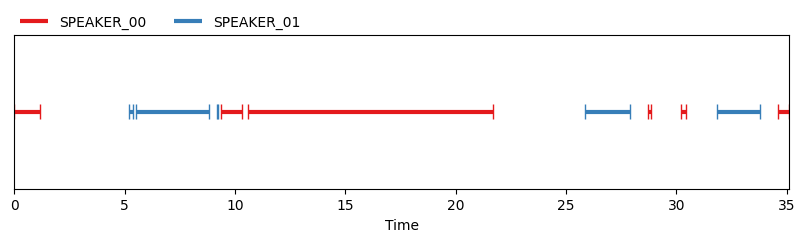

In [20]:
create_annotation_plot(video_output)

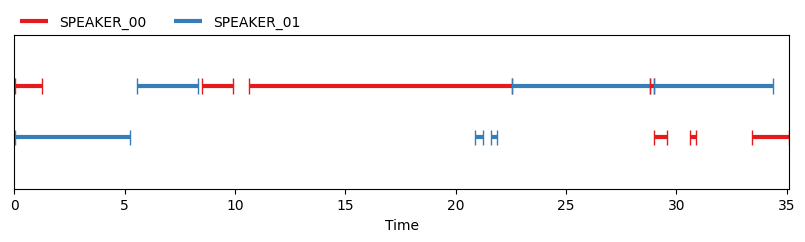

In [21]:
create_annotation_plot(audio_output)

In [22]:
video_audio_mapping = get_video_to_audio_mapping(video_output, audio_output)
video_audio_mapping

{'SPEAKER_00': 'SPEAKER_00', 'SPEAKER_01': 'SPEAKER_01'}

In [23]:
df = generate_openai_transcription(args.videoPath, model)

Transcribe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 38.13/38.13 [00:03<00:00, 11.46sec/s]


In [24]:
df["segment_end"] = df.apply(
    lambda row: (row["segment_end"] + 0.1) if row["segment_start"] == row["segment_end"] else row["segment_end"], axis=1
)
df["word_end"] = df.apply(
    lambda row: (row["word_end"] + 0.1) if row["word_start"] == row["word_end"] else row["word_end"], axis=1
)
segment_df = df[["segment_id", "segment_text", "segment_start", "segment_end"]].drop_duplicates().reset_index(drop=True)
word_df = df[["segment_id", "word", "word_start", "word_end"]]
segment_df["speaker_output"] = segment_df.apply(
    lambda row: get_segment_to_speaker_mapping(
        row["segment_start"], row["segment_end"], video_audio_mapping, audio_output
    ),
    axis=1,
)
segment_df["speaker_key"] = segment_df["speaker_output"].apply(lambda x: x[0])
segment_df["speaker_confidence"] = segment_df["speaker_output"].apply(lambda x: x[1])

In [25]:
segment_df["Subtitles"] = segment_df.apply(
    lambda row: srt.Subtitle(
        index=row["segment_id"] + 1,
        start=timedelta(seconds=row["segment_start"] - 0.1 if row["segment_start"] > 0.1 else row["segment_start"]),
        end=timedelta(seconds=row["segment_end"] + 0.1),
        content=f"{row['speaker_key']}: {row['segment_text']}"
    ),
    axis=1
)

In [26]:
# If name mapping known
name_mapping = {"SPEAKER_00": "Trump", "SPEAKER_01": "Piers"}
segment_df["Subtitles"] = segment_df.apply(
    lambda row: srt.Subtitle(
        index=row["segment_id"] + 1,
        start=timedelta(seconds=row["segment_start"] - 0.1 if row["segment_start"] > 0.1 else row["segment_start"]),
        end=timedelta(seconds=row["segment_end"] + 0.1),
        content=f"{name_mapping[row['speaker_key']]}: {row['segment_text']}"
    ),
    axis=1
)

In [27]:
srt_string = srt.compose(segment_df["Subtitles"].to_list())
with open(os.path.join(args.savePath, args.videoName + datetime.now().strftime("_%Y%m%d_%H%M%S") + ".srt"),
          "w",
         ) as f:
    f.write(srt_string)